In [1]:
import torch

import pickle

from matplotlib import pyplot as plt

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [2]:
dict_folder = "corpora/"
with open(dict_folder + 'pitches_corpus.pkl', 'rb') as f:
    pitches_corpus = pickle.load(f)

with open(dict_folder + 'volume_corpus.pkl', 'rb') as f:
    volume_corpus = pickle.load(f)

with open(dict_folder + 'duration_corpus.pkl', 'rb') as f:
    duration_corpus = pickle.load(f)

with open(dict_folder + 'offset_corpus.pkl', 'rb') as f:
    offset_corpus = pickle.load(f)

with open(dict_folder + "token_songs.pkl", "rb") as f:
    token_songs = pickle.load(f)

with open(dict_folder + "timing_corpus.pkl", "rb") as f:
    timing_corpus = pickle.load(f)

pitch_vectors = torch.load("./embeddings/pitch/dim200/vector100.pt")
volume_vectors = torch.load("./embeddings/volume/dim3/vector100.pt")
timing_vectors = torch.load("./embeddings/timing/dim53/vector100.pt")

In [3]:
def normalize_embeds(embeds: torch.Tensor):
    return (embeds-embeds.mean(0)) / embeds.std(dim=0)

In [4]:
pitch_embeds = normalize_embeds(pitch_vectors.sum(dim=0)).detach()
volume_embeds = normalize_embeds(volume_vectors.sum(dim=0)).detach()
timing_embeds = normalize_embeds(timing_vectors.sum(dim=0)).detach()

In [29]:
def groups2pca_plot(groups, embeds, title=None):
    torch.manual_seed(0)

    num_points = np.sum([len(group) for group in groups])
    data = torch.zeros(size=(num_points, embeds.size(1)))

    classes = []

    idx = 0
    for i,group in enumerate(groups):
        for id in group:
            data[idx] = embeds[id]
            idx += 1

            classes.append(i)

    pca = torch.pca_lowrank(data)
    pca_vectors = pca[0][:,:2]

    print(f"Values: {[x.item() for x in pca[1]]}")
    print(f"Number of data points: {num_points}")

    plt.figure(figsize=(10,10))
    plt.title(title)

    plt.scatter(pca_vectors[:,0], pca_vectors[:,1], c=classes, cmap="cool")

    return data, pca


In [30]:
def rank_similarity(vector: torch.Tensor, embeds: torch.Tensor, corpus: dict):
    sim_order = [i for i in range(embeds.size(0))]
    sim_order.sort(key = lambda x: vector.dot(embeds[x]).item(), reverse=True)

    print(f"Tokens most similar given vector are: {', '.join([str(list(corpus.keys())[x]) for x in sim_order[:6]])}")
    return sim_order

PCA Analysis

Values: [55.853492736816406, 44.94762420654297, 30.378170013427734, 27.913169860839844, 25.772384643554688, 23.81891632080078]
Number of data points: 81


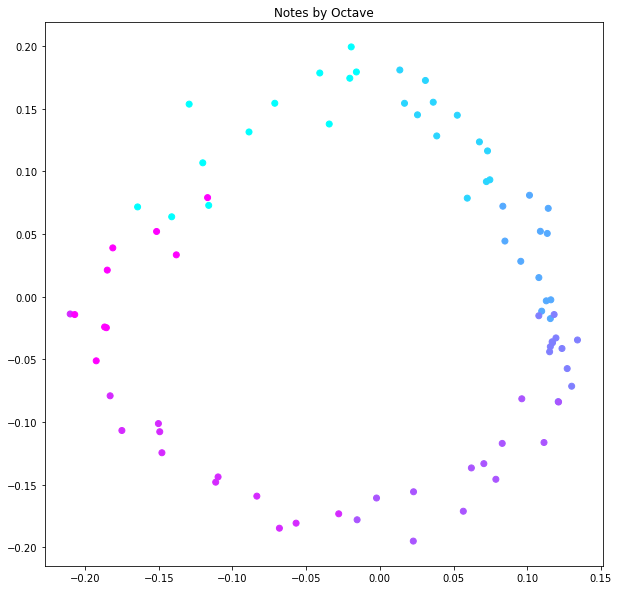

In [31]:
groups = [[] for i in range(999)]
for token,id in pitches_corpus.items():

    num_notes = len(token.split(" "))

    if num_notes != 1:
        continue

    for i in range(7):
        if str(i+1) in token:
            groups[i].append(id)
            break


data, pca = groups2pca_plot(groups, pitch_embeds, "Notes by Octave")

Values: [116.77159118652344, 79.7127685546875, 72.84671783447266, 72.59322357177734, 66.87201690673828, 63.71091842651367]
Number of data points: 2056


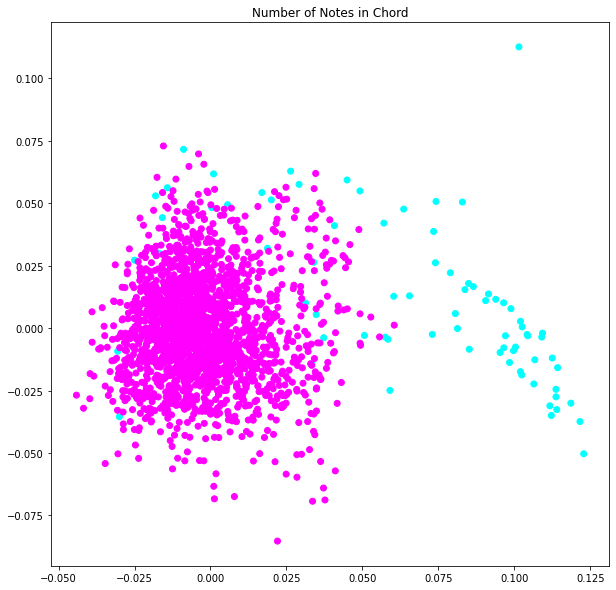

In [32]:
groups = [[] for i in range(7)]
for token,id in pitches_corpus.items():

    num_notes = len(token.split(" "))

    info_num = [1,2]

    if not num_notes in info_num:
        continue

    groups[info_num.index(num_notes)].append(id)


data, pca = groups2pca_plot(groups, pitch_embeds, "Number of Notes in Chord")

Values: [4.307219982147217, 3.2001450061798096, 1.098602294921875]
Number of data points: 11


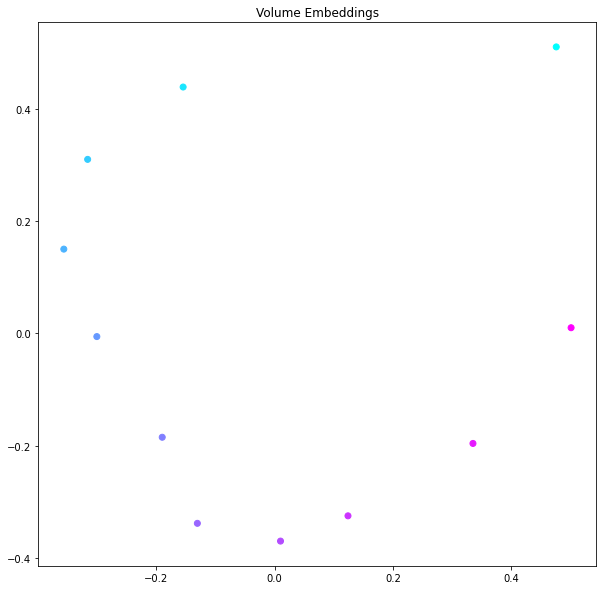

In [33]:
groups = [[] for i in range(999)]
for token,id in volume_corpus.items():
    groups[id].append(id)


data, pca = groups2pca_plot(groups, volume_embeds, title="Volume Embeddings")

Values: [31.874723434448242, 19.618608474731445, 19.237642288208008, 18.496471405029297, 16.561782836914062, 15.423771858215332]
Number of data points: 107


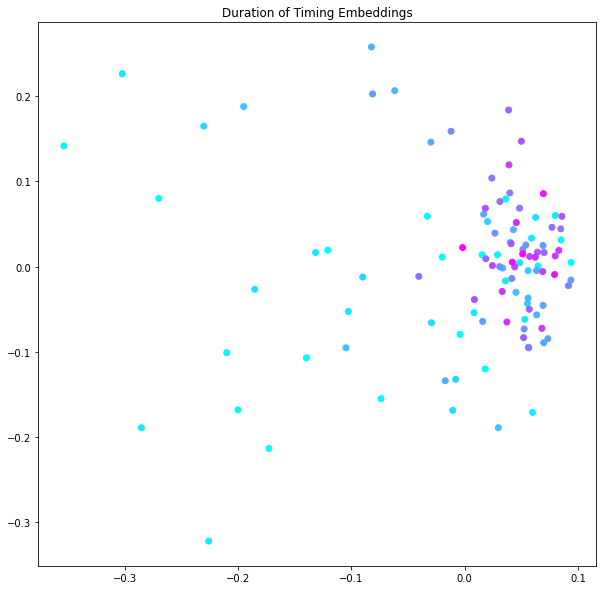

In [34]:
groups = [[] for i in range(999)]
for token,id in timing_corpus.items():
    dur_id, off_id = token.split(".")
    dur_id = int(dur_id)
    off_id = int(off_id)

    if dur_id > 5:
        continue
    if off_id > 999:
        continue

    groups[off_id].append(id)


data, pca = groups2pca_plot(groups, timing_embeds, title="Duration of Timing Embeddings")

Embedding Addition

In [35]:
token = "C3"
embed = pitch_embeds[pitches_corpus[token]]

sim_order = rank_similarity(embed, pitch_embeds, pitches_corpus)

Tokens most similar given vector are: C3, F3, C4, C2, G3, G2


In [36]:
token = "C4 E4 G4"
embed = pitch_embeds[pitches_corpus[token]]

sim_order = rank_similarity(embed, pitch_embeds, pitches_corpus)

Tokens most similar given vector are: C4 E4 G4, B3 D5 D6, E3 G3, C3 C4 G3, C3 C6, E4 G4


In [37]:
new_vec = pitch_embeds[pitches_corpus["A3"]] - pitch_embeds[pitches_corpus["C3"]] + pitch_embeds[pitches_corpus["C4"]]
desired_token = "A4"

sim_order = rank_similarity(new_vec, pitch_embeds, pitches_corpus)
print(f"{desired_token} is in location: {sim_order.index(pitches_corpus[desired_token])} / {len(sim_order)}")

Tokens most similar given vector are: A3, C4, D4, E4, C#4, B-3
A4 is in location: 6 / 16155


In [38]:
new_vec = pitch_embeds[pitches_corpus["A3 C3"]] - pitch_embeds[pitches_corpus["C3"]]
desired_token = "A3"

sim_order = rank_similarity(new_vec, pitch_embeds, pitches_corpus)
print(f"{desired_token} is in location: {sim_order.index(pitches_corpus[desired_token])} / {len(sim_order)}")

Tokens most similar given vector are: A3 C3, C4 D3 F#4, A4 A5 E-4, B4 E3 G4, E-6 F#3, D2 G3
A3 is in location: 16132 / 16155


In [39]:
token = 6/12
embed = volume_embeds[volume_corpus[token]]

sim_order = rank_similarity(embed, volume_embeds, volume_corpus)

Tokens most similar given vector are: 1/2, 5/12, 7/12, 1/3, 2/3, 1/4


In [40]:
token = "3.3"
embed = timing_embeds[timing_corpus[token]]

sim_order = rank_similarity(embed, timing_embeds, timing_corpus)

Tokens most similar given vector are: 3.3, 6.3, 3.6, 3.0, 6.6, 12.0
